In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob as tb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from wordcloud import WordCloud
import pyLDAvis, pyLDAvis.sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, PCA
pyLDAvis.enable_notebook()
style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('datasets/preprocessed_data_vader.csv')
df.rename({'Unnamed: 0' : 'index'}, axis=1, inplace=True)
df = df.set_index('index')
df.head(3)

,id,depth,parent_id,score,lemmatized,lemm_sub,sentiment,sentiment_sub,labels
index,,,,,,,,,
0,d4xury6,0,t3_4r2tl4,31,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,0.0772,0.9837,supporting
1,d4yi9y9,0,t3_4r2tl4,7,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,0.9184,0.9837,supporting
2,d4yhm4h,0,t3_4r2tl4,7,people nice friendly super non judgmental espe...,updated september scroll downhi lengthy post c...,0.9544,0.9837,commenting


## Text Representation

In [4]:
def texts_to_ngram(texts, n=2):
    texts = texts['lemmatized']
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000)
    dtm = vectorizer.fit_transform(texts)
    #pickle.dump(vectorizer, open('out/ngram.pk', 'wb'))
    return dtm, vectorizer

def texts_to_tfidf(texts):
    texts = texts['lemmatized']
    vectorizer = TfidfVectorizer(max_features=2000)
    tfidf = vectorizer.fit_transform(texts)
    #pickle.dump(vectorizer, open('out/tfidf.pk', 'wb'))
    return tfidf, vectorizer

In [5]:
# Get ngram matrix
ngram, ngram_v = texts_to_ngram(df, n=2)
print('Ngram matrix shape:', ngram.toarray().shape)
list(ngram_v.vocabulary_.items())[0:5]

Ngram matrix shape: (1155, 2000)


[('birth control', 85),
 ('one yet', 1196),
 ('meaningful answer', 1071),
 ('holy shit', 751),
 ('thank much', 1869)]

In [6]:
# Get TFIDF matrix
tfidf, tfidf_v = texts_to_tfidf(df)
print('TFIDF matrix shape:', tfidf.toarray().shape)
list(tfidf_v.vocabulary_.items())[0:5]

TFIDF matrix shape: (1155, 2000)


[('no', 1203),
 ('question', 1430),
 ('want', 1931),
 ('thank', 1796),
 ('post', 1358)]

## Term Frequencies

In [7]:
def vector_to_frequency(vector, vectorizer):
    """
    Return a list of words and their corresponding occurence in the corpus
    """
    total = vector.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    return frequency

In [8]:
freq_ngram = vector_to_frequency(ngram, ngram_v)
freq_ngram.head()

,term,frequency
0,birth control,81
1,side effect,61
2,get pregnant,42
3,copper iud,39
4,can not,39


In [9]:
freq_tfidf = vector_to_frequency(tfidf, tfidf_v)
freq_tfidf.head()

,term,frequency
0,pill,35.021105
1,get,34.569796
2,not,33.756021
3,condom,28.432744
4,use,24.500481


## Plotting Frequencies

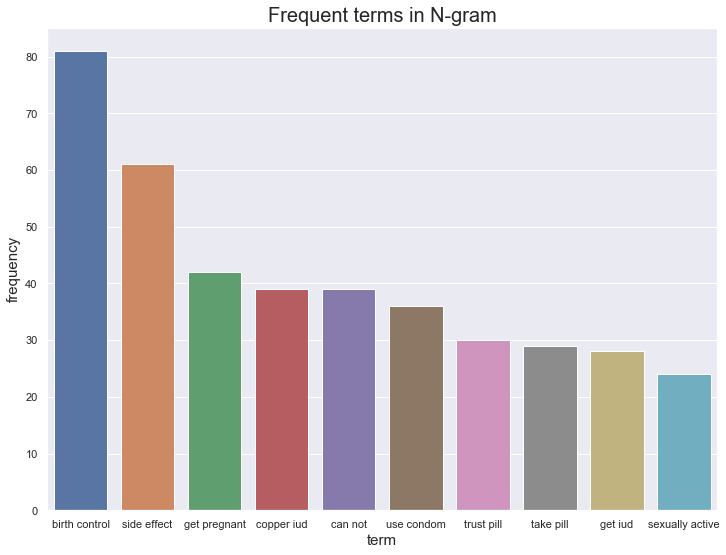

In [140]:
# Visualize frequencies
bar_ngram = sns.barplot(data=freq_ngram.head(10), x='term',
            y='frequency').set_title("Frequent terms in N-gram", fontsize=20)
sns.set(rc={
    'figure.figsize':(10.7,8.27),
    'font.size':15,
    'axes.titlesize':20,
    'axes.labelsize':15,
})

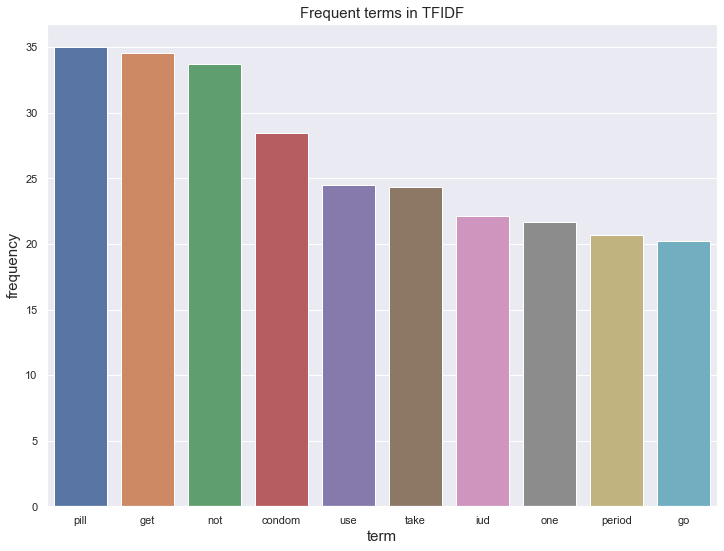

In [122]:
# Visualize frequencies
tfidf_ngram = sns.barplot(data=freq_tfidf.head(10), x='term',
            y='frequency').set_title("Frequent terms in TFIDF", fontsize=15)
sns.set(rc={
    'figure.figsize':(10.7,8.27),
    'font.size':15,
    'axes.titlesize':20,
    'axes.labelsize':15,
})

## Sentiment Analysis

#### Comments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123bd32e8>]],
      dtype=object)

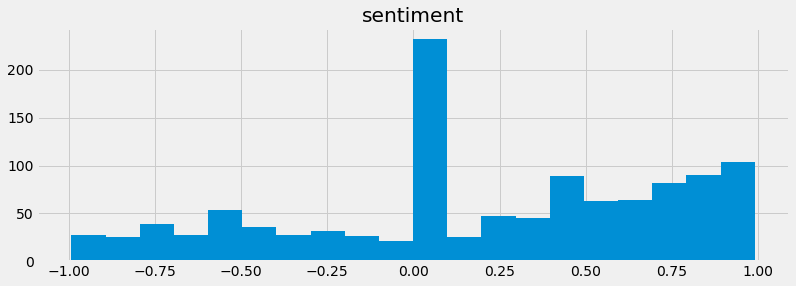

In [16]:
# Visualize distribution of sentiment and subjectivity
#sns.jointplot(data=df, x='sentiment', y='subjectivity', kind='reg') 

df.hist(column='sentiment', bins=20, figsize=(12,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123e55780>,
      dtype=object)

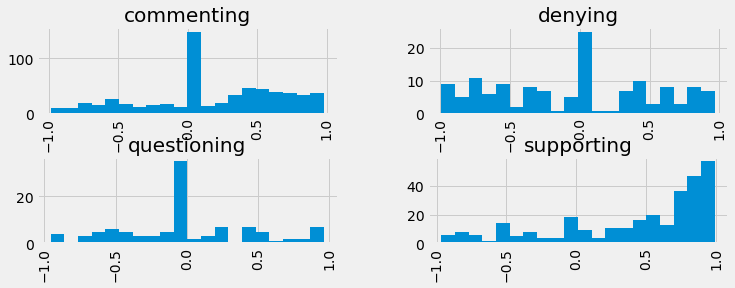

In [17]:
df.hist(column='sentiment', by='labels', bins=20, figsize=(12,4))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


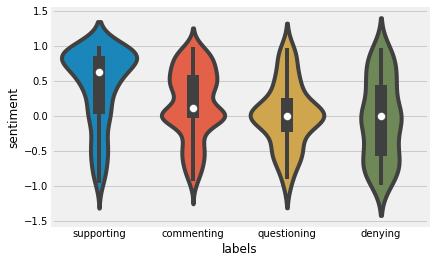

In [3]:
sns.violinplot(x="labels", y="sentiment", data=df)

In [61]:
df_parentsenti = df.copy()
def get_parent_senti(row):
    if row['depth'] == 0:
        return row['sentiment_sub']
    else:
        parent = row['parent_id'][3:]
        return df[df['id'] == parent]['sentiment']

df_parentsenti['sentiment_parent'] = df_parentsenti.apply(lambda row : get_parent_senti(row), axis=1)

In [63]:
# This is needed because some values become numpy arrays for some reason, so I have to convert
# them back to floats
def convert_to_int(curr):
    if type(curr) is np.ndarray:
        if len(curr) > 0:
            return curr[0]
        else:
            return 0
    else:
        return curr

# print(type(df_parentsenti.iloc[23]['sentiment_parent']) is np.ndarray)
df_parentsenti['sentiment_parent'] = df_parentsenti['sentiment_parent'].apply(
    lambda row : convert_to_int(row)
)
df_parentsenti['sentiment_parent'].head()

index
0    0.9837
1    0.9837
2    0.9837
3    0.9837
4    0.9837
Name: sentiment_parent, dtype: float64

In [67]:
df_parentsenti.tail(3)

,id,depth,parent_id,score,lemmatized,lemm_sub,sentiment,sentiment_sub,labels,sentiment_parent
index,,,,,,,,,,
1152,eak7tv3,3,t1_e3v6cng,1,update period go nag improve ung cramp flow se...,hi guy really want know virgin allow get iud f...,0.7476,0.5455,commenting,-0.3362
1153,e3vaacc,4,t1_e3v6fut,1,sure guess planning get one,hi guy really want know virgin allow get iud f...,0.6800,0.5455,commenting,0.4588
1154,eaoqp36,4,t1_eak7tv3,2,hi spotting heavier sure period heavy anything...,hi guy really want know virgin allow get iud f...,0.8943,0.5455,commenting,0.7476


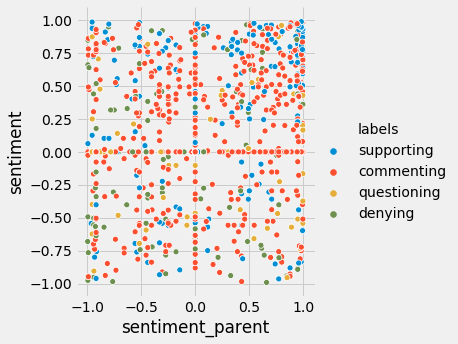

In [73]:
sns.relplot(x='sentiment_parent', y='sentiment', hue='labels', data=df_parentsenti)

## WordCloud

In [131]:
def create_wordcloud(texts, max_words=500):
    
    # Transform text for WordCloud
    texts = texts['lemmatized']
    texts = texts.dropna()
    texts = ' '.join(texts)
    texts = texts.replace(' ', ',')
    
    # Generate wordcloud image
    wc = WordCloud(background_color="white", max_words=max_words, colormap='plasma')
    wc.generate(texts)
    plt.imshow(wc, interpolation='bilinear')
    plt.title('WordCloud of Comments', size=30)
    plt.axis("off")

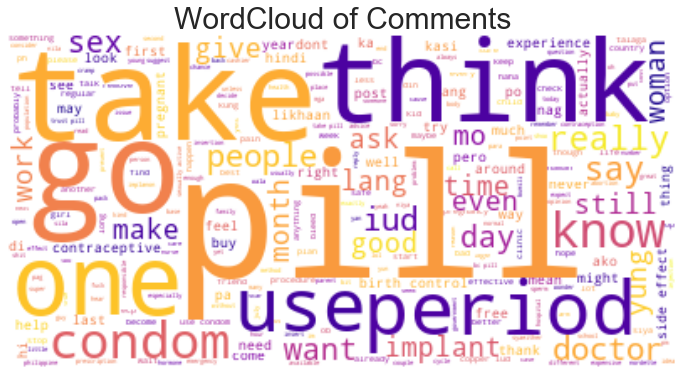

In [132]:
create_wordcloud(df)

## Text Modeling

In [125]:
# Load terms from existing vectorizers
ngram_terms = ngram_v.get_feature_names()
tfidf_terms = tfidf_v.get_feature_names()

### Latent Dirichlet Allocation

In [126]:
def lda(texts):
    """
    Executes LDA algorithm to determine topics of the corpus
    """
    lda_model = LatentDirichletAllocation(
        n_components=5, max_iter=10,
        learning_method='online', 
        learning_offset=50., random_state=0)
    lda_model.fit_transform(texts)
    return lda_model

In [127]:
# Execute LDA
ngram_lda = lda(ngram)
tfidf_lda = lda(tfidf)

In [128]:
ngram_lda = pyLDAvis.sklearn.prepare(ngram_lda, ngram, ngram_v)
pyLDAvis.save_html(ngram_lda, 'lda/ngram_lda.html')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [129]:
tfidf_lda = pyLDAvis.sklearn.prepare(tfidf_lda, tfidf, tfidf_v)
pyLDAvis.save_html(tfidf_lda, 'lda/tfidf_lda.html')

In [130]:
# Code obtained from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(tfidf)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, tfidf_v, number_words)

Topics found via LDA:

Topic #0:
day pill po period take yung lang hour mo ang

Topic #1:
store use post bring answer mean buy would cashier lazada

Topic #2:
ako condom pa prescription mo lang mga need nung see

Topic #3:
get not iud go one doctor no control birth people

Topic #4:
condom get use not free pill likhaan implant sex month
